# Data Cleaning and Exploratory Data Analysis

This notebook performs the cleaning and exploratory analysis of the Metacritic film dataset to understand data structure and quality.

**Datasets:**
- Sales data (box office, budget, opening weekend)
- Metacritic metadata (genres, ratings, release dates)
- Expert reviews (critical reception, sentiment)

---
## Setup & Configuration

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # For displaying heatmap
import seaborn as sns  # For correlation heatmap
from datetime import datetime
import warnings

from plotnine import *  # Import everything for visualization
import os
import scipy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # Print all outputs
from IPython.core.display import HTML  # Pretty print DataFrames
import re  # Added import for regular expressions
import pickle #for caching

from sklearn.preprocessing import MultiLabelBinarizer # for one hot encoding

warnings.filterwarnings('ignore')

---
### Defining Cache Functions

When working with multiple large Excel files (Sales, Metadata, and Expert reviews), the process of reading, cleaning, and merging data can become time-consuming. This system saves processed data for instant retrieval in future sessions, allowing our team to rerun the code faster, with less computing power.

**Implementation Logic and Configuration**
- The system consists of a configuration block and four core functions that handle the lifecycle of our data objects.

- The system uses a dedicated folder path and a global toggle (USE_CACHE) to easily enable or disable the feature.

**Core Functions**
- create_cache_folder(): Checks if the directory exists on our hard drive; if not, it creates it automatically to prevent errors during saving.

- get_cache_path(filename): Generates a standardized path for each file, ensuring all data objects are stored consistently as .pkl files.

- save_to_cache(data, filename): Uses Pickle Serialization to convert our Python DataFrames into a binary format and save them to the disk.

- load_from_cache(filename): Attempts to locate a saved file. If found, it "de-serializes" it back into a usable DataFrame; if not, it returns None, signaling the script to process the raw data instead.

In [2]:
# Code adapted from Ariana's DBMS group
# CONFIGURATION
CACHE_FOLDER = r"C:\Users\arian\Documents\cache_folder"
USE_CACHE = True

FILE_PATHS = {
    "sales_df": r"sales.xlsx",
    "meta_df": r"metaClean43Brightspace.xlsx",
    "expert_df": r"ExpertReviewsClean43LIWC (1).xlsx"
}

# CACHE MANAGEMENT FUNCTIONS
def create_cache_folder():
    """Create cache folder if it doesn't exist on the file system"""
    if not os.path.exists(CACHE_FOLDER):
        os.makedirs(CACHE_FOLDER)
        print(f"Created cache folder: {CACHE_FOLDER}")

def get_cache_path(filename):
    """Generate full file path for cached pickle file"""
    return os.path.join(CACHE_FOLDER, f"{filename}.pkl")

def save_to_cache(data, filename):
    """Save dataframe or data object to cache file using pickle serialization"""
    try:
        create_cache_folder()
        cache_path = get_cache_path(filename)
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)
        print(f" Cached {filename}")
    except Exception as e:
        print(f" Could not cache {filename}: {e}")

def load_from_cache(filename):
    """Load dataframe or data object from cache file if it exists"""
    try:
        cache_path = get_cache_path(filename)
        if os.path.exists(cache_path):
            with open(cache_path, 'rb') as f:
                data = pickle.load(f)
            print(f" Loaded {filename} from cache")
            return data
        else:
            return None
    except Exception as e:
        print(f" Could not load {filename} from cache: {e}")
        return None


---
# Data Loading and Merging Functions

**Core Project Pipeline**

This pipeline is designed to transform raw Excel data from disparate sources into a unified, analysis-ready DataFrame. It utilizes a modular approach, where each function handles a specific stage of the data lifecycle.

***Stage 1: Optimized Data Loading & Caching*** (above codeblock)

***Stage 2: String Normalization***
Because movie titles vary across sources (e.g., "The Matrix" vs "matrix"), an Aggressive Cleaning Helper is used to create "stable keys" for merging.

- clean_movie_name(text): This is the engine of the pipeline. It performs the following transformations:

- Converts to lowercase and strips whitespace.

- Removes URL paths, punctuation, and non-alphanumeric characters.

- Strips bracketed content (e.g., "[2024]") and trailing years (e.g., "1999").

- Collapses multiple spaces into single spaces.

***Stage 3: Title Generation per dataset***
These specialized functions ensure that every dataset contains a cleaned_title column derived from the best available source (URL, Title, or raw string).

- create_cleaned_title_for_sales(): Prioritizes the url column before falling back to standard Title.

- create_cleaned_title_for_meta(): Standardizes metadata titles for alignment with sales figures.

- create_cleaned_title_for_expert(): Prefers existing cleaned_title or standard Title columns.

***Stage 4: Movie ID Generation***
To avoid relying on volatile string keys, the pipeline generates a numeric movie_id.

create_movie_ids():
- Collects all unique cleaned_title values from every dataset.

- Creates a sorted master list (the movie_key).

- Assigns a unique integer ID to every film.

- Maps these IDs back to the original DataFrames and casts them as Int64 to handle potential missing values.

***Stage 5: Final Integration***
The final stage merges the separate entities into a single dataframe.

merge_datasets():
- Performs an Inner Merge between Metadata and Sales on movie_id.

- Merges the result with Expert reviews.

- Unifies the cleaned_title into a single canonical column.

- Drops any rows where a movie_id could not be assigned.

- Forces movie_id back to a whole number before returning the final DataFrame.

In [3]:
# Code adapted from Ariana's DBMS group

# Stage 1: Data Loading
def load_single_dataset(dataset_name, file_path):
    """Load a single dataset from cache or Excel file"""
    print(f"\nLoading {dataset_name}...")
    if USE_CACHE:
        cached_data = load_from_cache(dataset_name)
        if cached_data is not None:
            return cached_data

    try:
        print(f"  Loading from Excel: {file_path}")
        data = pd.read_excel(file_path)
        if USE_CACHE:
            save_to_cache(data, dataset_name)
        print(f"  Loaded {dataset_name} from Excel ({len(data)} rows)")
        return data
    except FileNotFoundError as e:
        print(f"  Error loading {dataset_name}: {e}")
        print("  Please check file path")
        raise

def load_all_datasets():
    """Load sales_df , meta_df , and Expert_df datasets"""
    print("Loading datasets...")
    datasets = {}
    for dataset_name, file_path in FILE_PATHS.items():
        datasets[dataset_name] = load_single_dataset(dataset_name, file_path)

    print("\nAll files loaded successfully!")
    for name, df in datasets.items():
        print(f"\n{name} columns:")
        print(df.columns.tolist())
        print(f"Shape: {df.shape}")
    return datasets


# Stage 2: Title/Nmae cleaning
def clean_movie_name(text):
    """
    Aggressive cleaning for generating stable keys / IDs.
    - Lowercase
    - Strip URL path / punctuation
    - Remove brackets & years
    - Collapse spaces
    """
    if pd.isna(text) or text is None:
        return ""
    name = str(text).lower().strip().rstrip("/")

    # If it's a URL, just use the last segment after '/'
    name = name.rsplit("/", 1)[-1]

    # Replace dashes/underscores with spaces
    name = name.replace("-", " ").replace("_", " ")

    # Remove bracketed content () or []
    name = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", name)

    # Remove non-alphanumeric (keep spaces)
    name = re.sub(r"[^a-z0-9 ]", "", name)

    # Remove trailing years like "1999" or "2016"
    name = re.sub(r"[\(\[]\s*(?:19|20)\d{2}[^)\]]*\s*[\)\]]\s*$|(?:19|20)\d{2}\s*$", "", name)

    # Collapse multiple spaces
    name = re.sub(r"\s+", " ", name).strip()

    return name

# stage 3: create cleaned_title for each dataset
def create_cleaned_title_for_sales(sales_df):
    """
    Ensure sales_df has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'url'
    - Else fall back to 'Title'/'title'
    - Else mark as empty
    """
    if "cleaned_title" in sales_df.columns:
        print("sales_df: 'cleaned_title' already exists, reusing.")
        return

    if "url" in sales_df.columns:
        source_col = "url"
        print("sales_df: creating 'cleaned_title' from 'url'")
    elif "Title" in sales_df.columns:
        source_col = "Title"
        print("sales_df: creating 'cleaned_title' from 'Title'")
    elif "title" in sales_df.columns:
        source_col = "title"
        print("sales_df: creating 'cleaned_title' from 'title'")
    else:
        print("sales_df: no suitable title-like column found, setting empty cleaned_title")
        sales_df["cleaned_title"] = ""
        return

    sales_df["cleaned_title"] = sales_df[source_col].apply(clean_movie_name)

def create_cleaned_title_for_meta(meta_df):
    """
    Ensure meta_file_clean has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'Title'/'title'
    - Else fall back to 'url'
    - Else mark as empty
    """
    if "cleaned_title" in meta_df.columns:
        print("meta_file_clean: 'cleaned_title' already exists, reusing.")
        return

    if "Title" in meta_df.columns:
        source_col = "Title"
        print("meta_df: creating 'cleaned_title' from 'Title'")
    elif "title" in meta_df.columns:
        source_col = "title"
        print("meta_df: creating 'cleaned_title' from 'title'")
    elif "url" in meta_df.columns:
        source_col = "url"
        print("meta_df: creating 'cleaned_title' from 'url'")
    else:
        print("meta_df: no suitable title-like column found, setting empty cleaned_title")
        meta_df["cleaned_title"] = ""
        return

    meta_df["cleaned_title"] = meta_df[source_col].apply(clean_movie_name)


def create_cleaned_title_for_expert(expert_df):
    """
    Ensure expert_df has a 'cleaned_title' column based on the best available source:
    - Prefer 'cleaned_title' if it already exists
    - Else prefer 'Title'/'title'
    - Else fall back to 'url'
    - Else mark as empty
    """
    if "cleaned_title" in expert_df.columns:
        print("expert_df: 'cleaned_title' already exists, reusing.")
        return

    if "Title" in expert_df.columns:
        source_col = "Title"
        print("expert_df: creating 'cleaned_title' from 'Title'")
    elif "title" in expert_df.columns:
        source_col = "title"
        print("expert_df: creating 'cleaned_title' from 'title'")
    elif "url" in expert_df.columns:
        source_col = "url"
        print("expert_df: creating 'cleaned_title' from 'url'")
    else:
        print("expert_df: no suitable title-like column found, setting empty cleaned_title")
        expert_df["cleaned_title"] = ""
        return

    expert_df["cleaned_title"] = expert_df[source_col].apply(clean_movie_name)


# stage 4: MOVIE ID generation based on cleaned_title
def create_movie_ids(datasets_dict):
    """
    Create stable movie_id values based ONLY on a single standardized 'cleaned_title'
    shared between meta_file_clean and sales_df.

    - cleaned_title is the canonical movie name (lowercase, stripped)
    - movie_id is generated from unique cleaned_title across both datasets
    - Any raw 'Title' / 'title' columns are left alone here but can be dropped later
    """
    sales_df = datasets_dict["sales_df"]
    meta_df = datasets_dict["meta_df"]
    expert_df = datasets_dict["expert_df"]

    # Build cleaned_title in both datasets
    create_cleaned_title_for_sales(sales_df)
    create_cleaned_title_for_meta(meta_df)
    create_cleaned_title_for_expert(expert_df)

    # Collect all cleaned titles from both
    all_cleaned = pd.concat([
        sales_df["cleaned_title"].dropna(),
        meta_df["cleaned_title"].dropna(),
        expert_df["cleaned_title"].dropna()
    ]).unique()

    # Filter out empty strings
    all_cleaned = [t for t in all_cleaned if isinstance(t, str) and t.strip() != ""]

    # Create movie_key dimension: movie_id ↔ cleaned_title
    movie_key = pd.DataFrame([
        {
            "movie_id": idx + 1,
            "cleaned_title": cleaned
        }
        for idx, cleaned in enumerate(sorted(all_cleaned))
    ])

    print(f"\nCreated movie_key with {len(movie_key)} unique movies")

    # Map cleaned_title -> movie_id
    name_to_id = dict(zip(movie_key["cleaned_title"], movie_key["movie_id"]))

    # Attach movie_id back to dataframes
    sales_df["movie_id"] = sales_df["cleaned_title"].map(name_to_id).astype("Int64")
    meta_df["movie_id"] = meta_df["cleaned_title"].map(name_to_id).astype("Int64")
    expert_df["movie_id"] = expert_df["cleaned_title"].map(name_to_id).astype("Int64")

    # drop any raw Title columns
    for df_name, df in [("sales_df", sales_df), ("meta_file_clean", meta_df), ("expert_df", expert_df)]:
        raw_title_cols = [c for c in df.columns if c.lower() == "title"]
        if raw_title_cols:
            df.drop(columns=raw_title_cols, inplace=True)
            print(f"{df_name}: dropped raw title columns {raw_title_cols}")

    return movie_key, sales_df, meta_df, expert_df


# stage 5: Merge datasets on movie_id
def merge_datasets(meta_df, sales_df, expert_df):
    # 1. Merge meta and sales first
    meta_sales = meta_df.merge(
        sales_df,
        on="movie_id",
        how="inner",
        suffixes=("_meta", "_sales")
    )

    # 2. Merge the result with the expert dataset
    merged = meta_sales.merge(
        expert_df,
        on="movie_id",
        how="inner",
        # Use a suffix for the new expert columns if there are name collisions
        suffixes=("", "_expert") 
    )
    print(f"\nMerged datasets on movie_id: {merged.shape[0]} rows")

    # unify cleaned_title
    if "cleaned_title_meta" in merged.columns and "cleaned_title_sales" in merged.columns:
        merged["cleaned_title"] = merged["cleaned_title_meta"]
        merged.drop(columns=["cleaned_title_meta", "cleaned_title_sales"], inplace=True)
        print("Merged: unified 'cleaned_title' column.")

    # Drop rows where movie_id was not assigned
    before = merged.shape[0]
    merged = merged[merged["movie_id"].notna()].copy()
    after = merged.shape[0]
    print(f"Dropped {before - after} rows due to missing movie_id")

    # Force the movie_id back to a whole number before returning
    merged["movie_id"] = merged["movie_id"].astype("Int64")

    return merged


# Run Above Funcitons
if __name__ == "__main__":
    # 1) Load datasets
    datasets = load_all_datasets()
    sales_df = datasets["sales_df"]
    meta_df = datasets["meta_df"]
    expert_df = datasets["expert_df"]

    # 2) Create standardized cleaned_title + movie_id
    movie_key, sales_df, meta_df, expert_df = create_movie_ids(datasets)

    # 3) Merge on movie_id with a single cleaned_title column
    merged_df = merge_datasets(meta_df, sales_df, expert_df)

    # 4) Quick sanity checks
    print("\n=== merged_df HEAD (movie_id, cleaned_title) ===")
    print(merged_df[["movie_id", "cleaned_title"]].head())

    print("\n=== movie_key HEAD ===")
    print(movie_key.head())

Loading datasets...

Loading sales_df...
 Loaded sales_df from cache

Loading meta_df...
 Loaded meta_df from cache

Loading expert_df...
 Loaded expert_df from cache

All files loaded successfully!

sales_df columns:
['year', 'release_date', 'title', 'genre', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime', 'keywords', 'creative_type', 'url']
Shape: (30612, 16)

meta_df columns:
['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'genre', 'summary', 'awards', 'metascore', 'userscore', 'RelDate']
Shape: (11364, 13)

expert_df columns:
['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', '

---
# Data Integration & Validation
We begin by verifying the success of merging the Sales, Metadata, and Expert Reviews datasets using movie_id.

We use set subtraction to identify "orphan" movies (those that didn't find a match across all three files) and compare unique IDs against unique titles to ensure our cleaning process was accurate.

In [4]:
# Ariana
meta_only_ids = set(meta_df['movie_id'].dropna()) - set(merged_df['movie_id'])
sales_only_ids = set(sales_df['movie_id'].dropna()) - set(merged_df['movie_id'])
expert_only_ids = set(expert_df['movie_id'].dropna()) - set(merged_df['movie_id'])

print("Meta-only movies:", len(meta_only_ids))
print("Sales-only movies:", len(sales_only_ids))
print("Expert-only movies:", len(expert_only_ids))

print("Merged rows:", len(merged_df))
print("Unique movie_ids in merged:", merged_df['movie_id'].nunique())
print("Unique cleaned_title in merged:", merged_df['cleaned_title'].nunique())

Meta-only movies: 4375
Sales-only movies: 23169
Expert-only movies: 4384
Merged rows: 179817
Unique movie_ids in merged: 6741
Unique cleaned_title in merged: 6741


**Key Results**
- Orphan Records: A large number of movies exist in individual datasets but do not overlap across all three, highlighting the diversity of the sources.

- Dataset Scale: The final merged dataset contains 179,817 rows, providing a massive sample size for analysis.

- Clean Integration: There are 6,741 unique movies in the final set.

- Consistency Check: The number of unique IDs (6,741) perfectly matches the number of unique titles (6,741), proving that the movie_id system is reliable.

## To get full understanding of what columns we have in this new, merged dataset, we print all the column names.

**This helps to understand the cleaning steps needed.**
1. We can see there are some columns that are duplicated: genre_meta and genre_sales columns. We only want 1 genre column.
2. We have 3 sales columns: Domestic, International, and Worldwide. We only want 1 sales column.
3. We have all expert reviews; however our focus is on only expert reviews that were posted before or on the Movie's release date (as these specific reviews might affect box office revenue). We must filter out reviews that were posted after the film's release.
4. There are many columns which are not useful for our study. These columns should be removed.

In [5]:
#Ariana
# print complete list of column names
print(merged_df.columns.tolist())

['url_meta', 'studio', 'rating', 'runtime_meta', 'cast', 'director', 'genre_meta', 'summary', 'awards', 'metascore', 'userscore', 'RelDate', 'movie_id', 'year', 'release_date', 'genre_sales', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'production_budget', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre', 'runtime_sales', 'keywords', 'creative_type', 'url_sales', 'url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affili

### To begin, we merge the 2 genre columns together, making sure to keep all genre's present from both columns, having each genre listed once.

In [6]:
#Ariana
# 1. Combine genre columns from different datasets into one long string
raw_text = merged_df['genre_sales'].fillna('') + "," + merged_df['genre_meta'].fillna('')

# 2. Clean it up: Split by comma -> Remove Duplicates (set) -> Join back
# We also verify 'if s.strip()' to make sure we don't include empty spaces
merged_df['genre'] = raw_text.apply(lambda x: ", ".join(set(s.strip() for s in x.split(',') if s.strip())))

# 3. Drop the old columns
merged_df = merged_df.drop(columns=['genre_sales', 'genre_meta'])

### Now, we merge our revenue columns together, creating a new column called 'total_revenue'

In [7]:
#Ariana
# Ensure columns are numeric (converts errors to NaN) -> This prevents crashes if your data has "$" signs or commas (e.g. "$1,000")
cols_to_fix = ['worldwide_box_office', 'international_box_office', 'domestic_box_office']
for col in cols_to_fix:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Define the logic function
def calculate_total_revenue(row):
    ww = row['worldwide_box_office']
    
    # Check if worldwide exists (not NaN) AND is not 0
    if pd.notna(ww) and ww != 0:
        return ww
    
    # if worldwide doesnt exist: Sum International + Domestic
    intl = row['international_box_office'] if pd.notna(row['international_box_office']) else 0
    dom = row['domestic_box_office'] if pd.notna(row['domestic_box_office']) else 0
    
    return intl + dom

# 3. Apply the function
merged_df['total_revenue'] = merged_df.apply(calculate_total_revenue, axis=1)


### Next, we drop all columns that will no longer be needed.

In [8]:
# drop all columns except those below
columns_to_keep = [
    "genre",
    "opening_weekend",
    "production_budget",
    "year",
    "release_date",
    "movie_id",
    "cleaned_title",
    "Rev",
    "total_revenue",
    "dateP"
]

merged_cleaned_df = merged_df[columns_to_keep]

# To verify the change:
print(merged_cleaned_df.head())

print("Columns after cleaning:")
print(merged_cleaned_df.columns)
print("Shape:", merged_cleaned_df.shape)

         genre  opening_weekend  production_budget  year release_date  \
0  Documentary           5791.0                NaN  2011     June 1st   
1  Documentary           5791.0                NaN  2011     June 1st   
2  Documentary           5791.0                NaN  2011     June 1st   
3  Documentary           5791.0                NaN  2011     June 1st   
4  Documentary           5791.0                NaN  2011     June 1st   

   movie_id         cleaned_title  \
0     33445  women art revolution   
1     33445  women art revolution   
2     33445  women art revolution   
3     33445  women art revolution   
4     33445  women art revolution   

                                                 Rev  total_revenue  \
0   'These interviews form the backbone of !W.A.R...        52681.0   
1   'In her vibrant !Women Art Revolution Hershma...        52681.0   
2   'It took 42 years for filmmaker Lynn Hershman...        52681.0   
3   'Anyone seeking a dialectic, of course, can l...  

### Now that we have a smaller dataframe, we can go ahead and drop the expert reviews posted after the movie's release

In [9]:
#Ariana
#drop expert reviews posted after release date (using "year" and "release_date" vs "dateP")
# 1. Clean the 'release_date' text to remove st/nd/rd/th
# Logic: Look for digits followed by st, nd, rd, or th and replace the suffix with nothing.
# Example: "June 1st" becomes "June 1"
merged_cleaned_df['release_date_clean'] = merged_cleaned_df['release_date'].astype(str).str.replace(r'(?<=\d)(st|nd|rd|th)', '', regex=True)

# 2. Create a combined string column (Year + Month + Day)
# Example: "2011" + " " + "June 1" = "2011 June 1"
merged_cleaned_df['full_date_str'] = merged_cleaned_df['year'].astype(str) + ' ' + merged_cleaned_df['release_date_clean']

# 3. Convert that string into a real Datetime object
merged_cleaned_df['full_release_date'] = pd.to_datetime(merged_cleaned_df['full_date_str'], errors='coerce')

# 4. Convert your Review Date (dateP) to datetime as well
merged_cleaned_df['dateP'] = pd.to_datetime(merged_cleaned_df['dateP'], errors='coerce')

# Apply the filter

# Keep rows where the Review Date is BEFORE or ON the specific Release Date
mask = (merged_cleaned_df['dateP'] <= merged_cleaned_df['full_release_date']) & \
       (merged_cleaned_df['dateP'].notna()) & \
       (merged_cleaned_df['full_release_date'].notna())

merged_cleaned_df = merged_cleaned_df[mask]

# Rename and clean up
merged_cleaned_df = merged_cleaned_df.rename(columns={'Rev': 'prerelease_reviews'})

# Check the results
print(f"Remaining rows: {len(merged_cleaned_df)}")
print(merged_cleaned_df[['dateP', 'full_release_date', 'prerelease_reviews']].head())

Remaining rows: 65115
        dateP full_release_date  \
8  2011-05-31        2011-06-01   
11 2016-03-11        2016-03-11   
12 2016-03-10        2016-03-11   
13 2016-03-10        2016-03-11   
14 2016-03-10        2016-03-11   

                                   prerelease_reviews  
8    'Thankfully, Lynn Hershman-Leeson s loosely o...  
11   'Economically told from the start, the film m...  
12   'This is a terrific movie that will keep audi...  
13   'Sneakily tweaking our fears of terrorism, 10...  
14   'Approach 10 Cloverfield Lane on its own term...  


### Finally, we can drop the columns that were used to do the above deletion.

**We are left with only the columns needed to conduct this study.**

In [10]:
#Ariana
# List of all columns to remove
# We use errors='ignore' so it won't crash if one of these is already gone
cols_to_remove = [
    'dateP', 
    'year', 
    'release_date',
    'release_date_clean',  
    'full_date_str'        
]

# Drop them
merged_cleaned_df = merged_cleaned_df.drop(columns=cols_to_remove, errors='ignore')

# Verify they are gone
print("Remaining columns:")
print(merged_cleaned_df.columns.tolist())

#rename df to merged_df
merged_df = merged_cleaned_df

Remaining columns:
['genre', 'opening_weekend', 'production_budget', 'movie_id', 'cleaned_title', 'prerelease_reviews', 'total_revenue', 'full_release_date']


### Our current dataframe (merged_df) includes prerelease_reviews. This creates an issue when conducting further EDA due to some movies having multiple reviews.

**To solve this, we create a new dataframe (movie_stats_df) without the prerelease_reviews column**

In [11]:
#Ariana
# df1: Used for analyzing Revenue, Budget, and Genre trends
movie_stats_df = merged_df.drop_duplicates(subset=['movie_id']).copy()

movie_stats_df.drop(columns=['prerelease_reviews'], inplace=True, errors='ignore')

**To ensure our movie_stats_df does not contain duplicated movies, we print the % of duplicate rows in the dataframe, along with the number of unique movies and total rows - these numbers should match. Lastly, we check that the average rows per movie is 1.**

In [12]:
# Benita
# Ensure movie_stats_df does not have duplicates
duplicates = movie_stats_df.duplicated().sum()
print(f"Duplicate rows: {duplicates:,} ({duplicates/len(movie_stats_df)*100:.2f}%)")

if 'movie_id' in movie_stats_df.columns:
    unique_movies = movie_stats_df['movie_id'].nunique()
    total_rows = len(movie_stats_df)
    print(f"\nUnique movies: {unique_movies:,}")
    print(f"Total rows: {total_rows:,}")
    print(f"Average rows per movie: {total_rows/unique_movies:.1f}")

Duplicate rows: 0 (0.00%)

Unique movies: 3,475
Total rows: 3,475
Average rows per movie: 1.0


**This codeblock uses the .info() and .describe() methods to provide a high-level overview of the cleaned movie_stats_df and its financial distributions. It confirms that the dataset contains 3,475 unique films with correctly formatted date and ID columns.**


In [13]:
# Benita
print("\nData Types and Non-Null Counts:")
movie_stats_df.info()

print("\nNumeric Columns - Summary Statistics:")
movie_stats_df.describe()


Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
Index: 3475 entries, 8 to 218857
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre              3475 non-null   object        
 1   opening_weekend    2442 non-null   float64       
 2   production_budget  1243 non-null   float64       
 3   movie_id           3475 non-null   Int64         
 4   cleaned_title      3475 non-null   object        
 5   total_revenue      3475 non-null   float64       
 6   full_release_date  3475 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), float64(3), object(2)
memory usage: 220.6+ KB

Numeric Columns - Summary Statistics:


,opening_weekend,production_budget,movie_id,total_revenue,full_release_date
count,2.442000e+03,1.243000e+03,3475.0,3.475000e+03,3475
mean,9.283198e+06,4.645761e+07,16158.050935,5.475785e+07,2016-03-10 03:13:06.302158336
min,8.600000e+01,2.000000e+04,10.0,0.000000e+00,2010-10-22 00:00:00
25%,1.291275e+04,9.650000e+06,7622.0,1.884200e+04,2013-09-23 12:00:00
50%,9.886150e+04,2.500000e+07,15619.0,4.370890e+05,2016-02-12 00:00:00
75%,8.751153e+06,5.950000e+07,24148.5,2.248372e+07,2018-07-29 12:00:00
max,3.571150e+08,4.000000e+08,34361.0,2.797801e+09,2021-12-29 00:00:00
std,2.343134e+07,5.694714e+07,9808.36849,1.690022e+08,NaN


---
## Data Quality Assessment

To assess the reliability of our findings, we performed a Missing Data Analysis across the cleaned movie_stats_df. Identifying gaps in the dataset is crucial for understanding the limitations of our financial modeling.

**Implementation Logic**
The analysis calculates both the raw count and the percentage of missing values (null or NaN) for every column in the dataset.

- Calculation: The script uses .isnull().sum() to find missing values and divides by the total length of the DataFrame to get a percentage.

- Visualization: A horizontal bar chart was generated to highlight the "top offenders" - columns with the highest frequency of missing data - allowing for immediate visual identification of data gaps.

Missing Data Summary:
                   Missing_Count  Percentage
production_budget           2232   64.230216
opening_weekend             1033   29.726619


<BarContainer object of 2 artists>

Text(0.5, 0, 'Missing Percentage (%)')

Text(0.5, 1.0, 'Top 15 Columns with Missing Data')

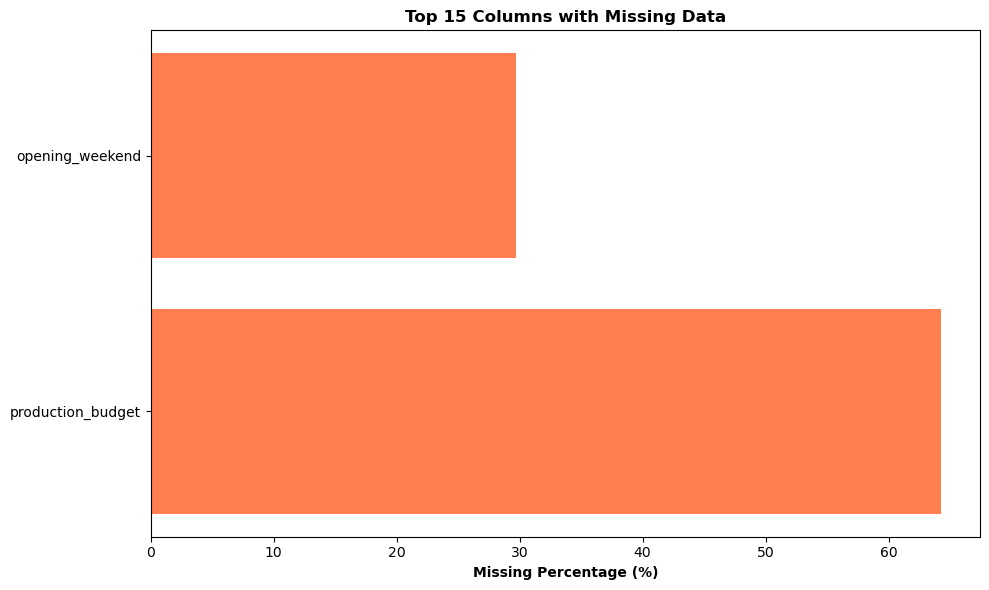

In [14]:
# # Benita
# Check missing values
missing = movie_stats_df.isnull().sum()
missing_pct = (missing / len(movie_stats_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("Missing Data Summary:")
print(missing_df[missing_df['Percentage'] > 0].head(10))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
top_missing = missing_df[missing_df['Percentage'] > 0].head(15)
ax.barh(top_missing.index, top_missing['Percentage'], color='coral')
ax.set_xlabel('Missing Percentage (%)', fontweight='bold')
ax.set_title('Top 15 Columns with Missing Data', fontweight='bold')
plt.tight_layout()
plt.show()

Figure #1.1 : Columns with missing data

### Key Insights
- Budget Data Scarcity: Production Budget is the most incomplete metric, with 64.2% of films missing this data point. This indicates that financial conclusions regarding ROI should be focused on the subset of 1,243 films where this data is available.

- Debut Performance Gaps: Approximately 29.7% of films are missing Opening Weekend figures.

- Reliable Columns: Since only two columns appeared in the "Top 15" visualization with percentages above zero, we can conclude that core identifiers like movie_id, cleaned_title, and total_revenue are 100% complete across the 3,475 unique film entries.

---
## Business Context Analysis

To assess the commercial viability of the films, we analyzed the core "success metrics": Total Revenue, Production Budget, and Opening Weekend performance. This analysis culminates in a high-level profitability ratio for the industry.

**Implementation Logic**
The code identifies key financial columns and calculates standard descriptive statistics (Mean, Median, and Max). A critical feature is the Profitability Calculation, which compares revenue against budget on a per-film basis.

- Metric Selection: The script dynamically searches for columns containing keywords like "revenue", "budget", and "opening".

- Central Tendency: Both Mean and Median are calculated; the large gap between these two values (as seen in the output) highlights the impact of extreme blockbuster outliers on industry averages.

- Profitability Logic: A film is flagged as "profitable" if its total_revenue exceeds its production_budget. This calculation is performed on the subset of 1,243 films that contain both data points.

In [15]:
# Benita and Ariana
# Find revenue and budget columns
revenue_col = None
budget_col = None
opening_col = None

for col in movie_stats_df.columns:
    if 'revenue' in col.lower() or 'worldwide' in col.lower():
        revenue_col = col
    if 'budget' in col.lower():
        budget_col = col
    if 'opening' in col.lower():
        opening_col = col

print("Financial Metrics Overview:")

if revenue_col:
    print(f"\n{revenue_col}:")
    print(f"  Mean: ${movie_stats_df[revenue_col].mean():,.0f}")
    print(f"  Median: ${movie_stats_df[revenue_col].median():,.0f}")
    print(f"  Max: ${movie_stats_df[revenue_col].max():,.0f}")

if budget_col:
    print(f"\n{budget_col}:")
    print(f"  Mean: ${movie_stats_df[budget_col].mean():,.0f}")
    print(f"  Median: ${movie_stats_df[budget_col].median():,.0f}")

if opening_col:
    print(f"\n{opening_col}:")
    print(f"  Mean: ${movie_stats_df[opening_col].mean():,.0f}")
    print(f"  Median: ${movie_stats_df[opening_col].median():,.0f}")

# Calculate profitability
if revenue_col and budget_col:
    profitable = (movie_stats_df[revenue_col] > movie_stats_df[budget_col]).sum()
    total = movie_stats_df[[revenue_col, budget_col]].dropna().shape[0]
    print(f"\nProfitability: {profitable}/{total} films ({profitable/total*100:.1f}%) profitable")

Financial Metrics Overview:

total_revenue:
  Mean: $54,757,850
  Median: $437,089
  Max: $2,797,800,564

production_budget:
  Mean: $46,457,606
  Median: $25,000,000

opening_weekend:
  Mean: $9,283,198
  Median: $98,862

Profitability: 884/1243 films (71.1%) profitable


**Key Business Insights**
- The "Hit" Phenomenon: The Mean Revenue ($54.7M) is significantly higher than the Median Revenue ($437K). This confirms that a small number of massively successful films generate the bulk of the industry's total earnings, while the "typical" movie earns far less.

- Average Investment: The average production budget for a film in this dataset is approximately $46.5M, while the median investment is lower at $25.0M.

- Profitability Baseline: Approximately 71.1% (884 out of 1,243) of the films analyzed were profitable, earning more in total revenue than their initial production costs.

- Opening Weekend Impact: The average debut brings in $9.2M, representing roughly 17% of the eventual average total revenue.

---
# Financial Distributions
To understand the typical scale of film investments and their returns, histograms were generated for both budgets and revenues. These visualizations help identify the "common" financial range for most films versus the "blockbuster" outliers.

**Implementation Logic**
The plotting code uses matplotlib subplots to display two distributions side-by-side.

Data Cleaning: The .dropna() method is used on each column within the plot call to ensure missing values do not interfere with the binning logic.

Visual Styling: blue was chosen for budgets and green for revenue to provide a clear visual distinction between cost and income.

<Axes: >

Text(0.5, 1.0, 'Budget Distribution')

Text(0.5, 0, 'Production Budget ($)')

Text(0, 0.5, 'Number of Films')

<Axes: >

Text(0.5, 1.0, 'Revenue Distribution')

Text(0.5, 0, 'Total Revenue ($)')

Text(0, 0.5, 'Number of Films')

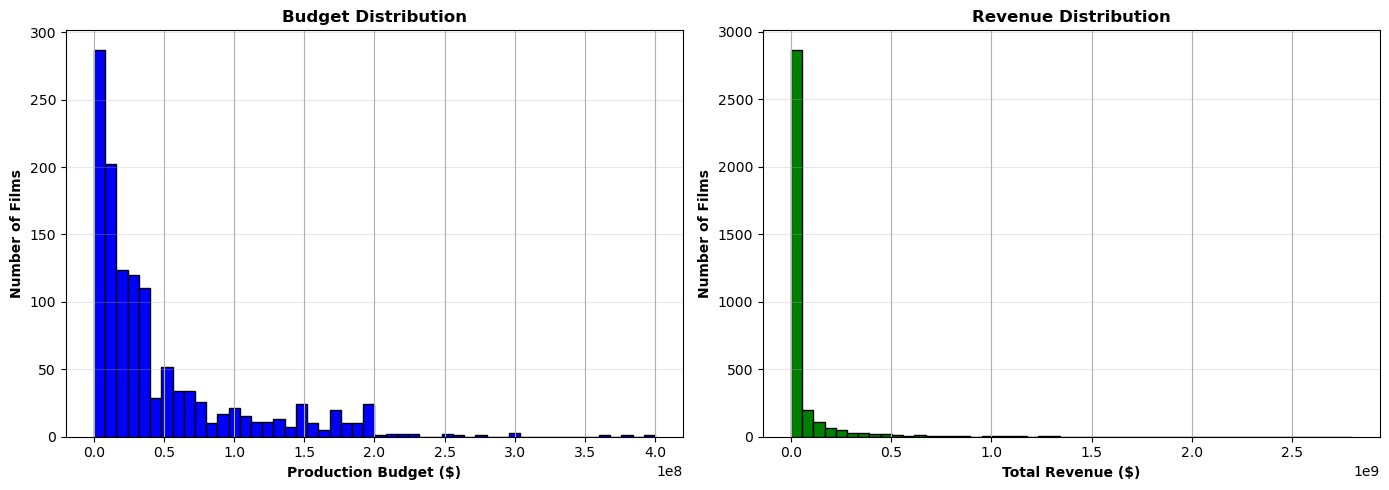

In [16]:
# Benita and Ariana
# Visualize financial distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if budget_col:
    movie_stats_df[budget_col].dropna().hist(bins=50, ax=axes[0], color='blue', edgecolor='black')
    axes[0].set_title('Budget Distribution', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Production Budget ($)', fontweight='bold')
    axes[0].set_ylabel('Number of Films', fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')

if revenue_col:
    movie_stats_df[revenue_col].dropna().hist(bins=50, ax=axes[1], color='green', edgecolor='black')
    axes[1].set_title('Revenue Distribution', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Total Revenue ($)', fontweight='bold')
    axes[1].set_ylabel('Number of Films', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Figure #1.2 : Budget vs. Revenue Distribution

**Key Insights from the Distributions**

Right-Skewed Data: Both distributions are heavily right-skewed, meaning the vast majority of films have relatively low budgets and revenues, while a small number of "hits" exist at the far right of the scale.

Budget Concentration: Most films in the dataset have production budgets under $50 million (indicated by the high concentration of bars near the 0.0 on the x-axis).

Revenue Concentration: Similarly, the revenue distribution shows that most movies earn less than $100 million in total revenue, with very few films crossing the $1 billion mark.

Scale Differences: Note that the x-axis for revenue (up to $2.5 \times 10^9$) extends significantly further than the budget axis (up to $4.0 \times 10^8$), reflecting that successful films often earn several times their production costs.

---
# Temporal Analysis
To understand how the film industry's financial performance evolves over time and identify seasonal peaks, the dataset was analyzed by release year and quarter.

**Implementation Logic**
The analysis script dynamically identifies a date column and a revenue column to perform grouping.

- Data Conversion: The pd.to_datetime function is used to convert string dates into a standardized datetime format.

- Feature Extraction: New columns for release_year, release_quarter, and release_month are extracted to allow for multi-level granularity.

- Filtering: To ensure statistical relevance, year-over-year trends are filtered to only include years with at least 10 films.

- Normalization: Quarterly averages are divided by 1e6 to present the results in millions ($M) for better readability.

In [17]:
# Benita and Ariana
# Temporal analysis
date_col = None
for col in movie_stats_df.columns:
    if 'release_date' in col.lower():
        date_col = col
        break

if date_col and revenue_col:
    print(f"Temporal Analysis (using {date_col}):")
    
    # Convert to datetime
    movie_stats_df['date_dt'] = pd.to_datetime(movie_stats_df[date_col], errors='coerce')
    movie_stats_df['release_year'] = movie_stats_df['date_dt'].dt.year
    movie_stats_df['release_quarter'] = movie_stats_df['date_dt'].dt.quarter
    movie_stats_df['release_month'] = movie_stats_df['date_dt'].dt.month
    
    # Year trends
    yearly = movie_stats_df.groupby('release_year')[revenue_col].agg(['mean', 'count'])
    yearly = yearly[yearly['count'] >= 10]  # At least 10 films per year
    
    print(f"\nData spans: {movie_stats_df['release_year'].min():.0f} to {movie_stats_df['release_year'].max():.0f}")
    print(f"Total years: {movie_stats_df['release_year'].nunique()}")
    
    # Quarterly patterns
    quarterly = movie_stats_df.groupby('release_quarter')[revenue_col].mean() / 1e6
    
    print("\nAverage Revenue by Quarter:")
    for q, rev in quarterly.items():
        print(f"  Q{int(q)}: ${rev:.1f}M")
else:
    print("Date column not found - skipping temporal analysis")

Temporal Analysis (using full_release_date):

Data spans: 2010 to 2021
Total years: 12

Average Revenue by Quarter:
  Q1: $46.9M
  Q2: $71.0M
  Q3: $40.9M
  Q4: $60.1M


**Key Insights**
- Data Longevity: The dataset spans a 12-year period from 2010 to 2021, providing a decade-long view of industry trends.

- Peak Season (Q2): The second quarter (April–June) is the strongest performing period, with an average revenue of $71.0M. This likely aligns with the release of major "Summer Blockbusters."

- Secondary Peak (Q4): The fourth quarter (October–December) follows with $60.1M, historically driven by holiday season releases and award-contending films.

- Slower Periods (Q1 & Q3): The third quarter ($40.9M) and first quarter ($46.9M) show significantly lower average returns, representing the off-peak windows in the theatrical calendar.

---
# Correlation Analysis
To understand how different financial metrics relate to one another, a correlation matrix and heatmap were generated. This helps identify if a higher investment (budget) typically leads to a stronger debut (opening weekend) or higher overall success (total revenue).

**Implementation Logic**
The analysis automatically filters for numeric columns related to key financial keywords: revenue, budget, and opening. By using a Pearson Correlation, we can measure the linear strength between these variables on a scale from -1 to 1.

Correlation Matrix - Key Variables:
                   opening_weekend  production_budget  total_revenue
opening_weekend           1.000000           0.733348       0.928582
production_budget         0.733348           1.000000       0.778042
total_revenue             0.928582           0.778042       1.000000


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap - Financial Variables')

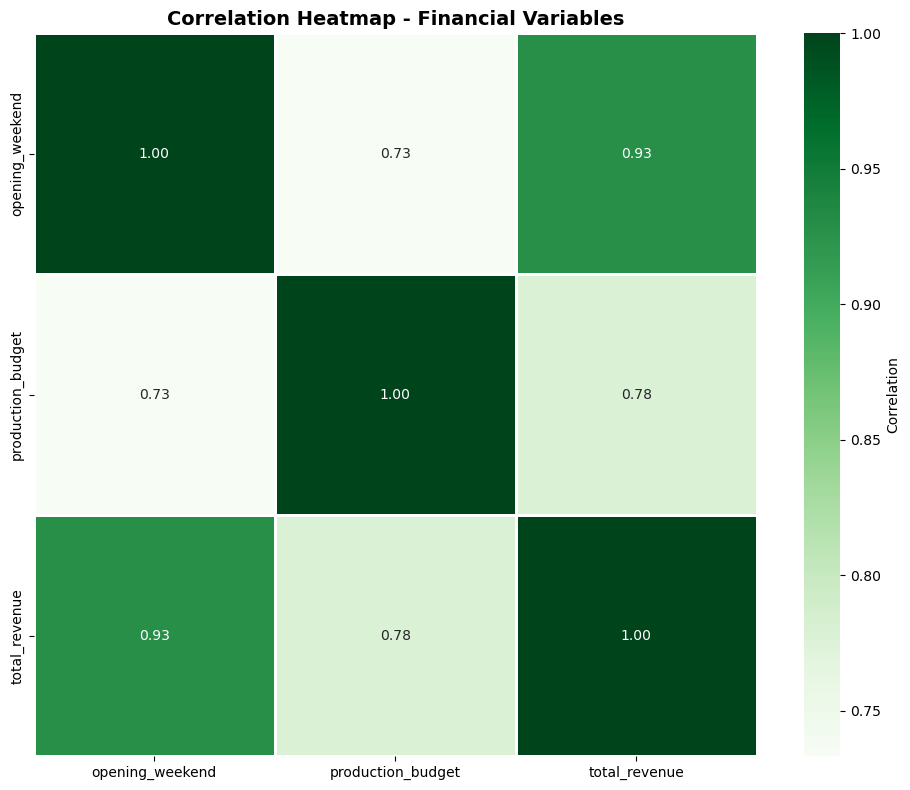

In [18]:
# Benita and Ariana
# Correlation analysis
numeric_cols = movie_stats_df.select_dtypes(include=[np.number]).columns.tolist()

# Find key financial columns
key_cols = []
for col in numeric_cols:
    if any(keyword in col.lower() for keyword in ['revenue', 'budget', 'opening', 'score']):
        key_cols.append(col)

if len(key_cols) >= 2:
    print("Correlation Matrix - Key Variables:")    
    # Calculate correlation
    corr_matrix = movie_stats_df[key_cols].corr()
    print(corr_matrix)
    
    # Visualize
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt='.2f', 
                linewidths=1, square=True, cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Heatmap - Financial Variables', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()


Figure #1.3 : Correlation Heatmap

**Key Insights from the Correlation Map**
- Strongest Relationship (0.93): There is an extremely high correlation between Opening Weekend and Total Revenue. This suggests that a movie's initial performance is a very strong predictor of its final financial outcome.

- Budget vs. Success (0.78): Production Budget has a strong positive correlation with Total Revenue. While "throwing money at a project" doesn't guarantee a hit, larger investments generally align with higher returns in this dataset.

- Investment vs. Debut (0.73): There is a solid correlation between Production Budget and Opening Weekend, indicating that high-budget films often benefit from the massive marketing pushes required to secure a big opening.

---
# Profitability Analysis

### To evaluate the relationship between investment and return, a comparison between Production Budget and Total Revenue was performed.

**Implementation Logic:**
Because movie financial data often spans from thousands to billions, a Logarithmic Scale was applied to both axes. This prevents extreme outliers from compressing the majority of the data points into the corner of the graph, allowing for a clearer view of the overall trend.

**Key Insights from the Graph**
- The Break-even Line: The red dashed line represents the point where Revenue = Budget.

- Profitability Zone: Data points located above the red line represent movies that earned more than their reported production costs.

- Loss Zone: Data points below the line indicate films that failed to recoup their initial production investment.

- Correlation: There is a visible positive correlation; as production budgets increase, total revenues tend to increase as well, though with significant variance at every budget level.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='production_budget', ylabel='total_revenue'>

Text(0.5, 1.0, 'Production Budget vs. Total Revenue (Log Scale)')

Text(0.5, 0, 'Production Budget ($)')

Text(0, 0.5, 'Total Revenue ($)')

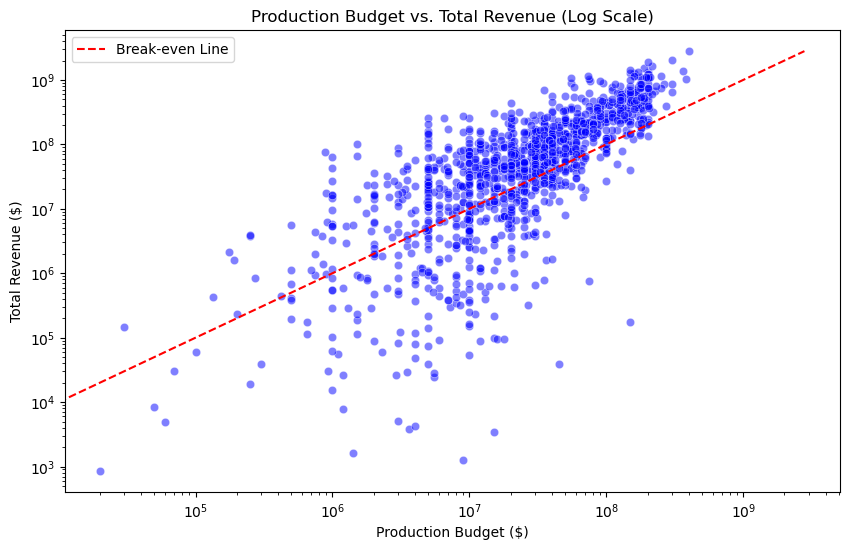

In [19]:
# Ariana
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movie_stats_df, x='production_budget', y='total_revenue', alpha=0.5, color='blue')

# Add a diagonal line (Break-even line)
# Movies below this line lost money. Movies above it made a profit.
max_val = max(movie_stats_df['production_budget'].max(), movie_stats_df['total_revenue'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Break-even Line')

plt.xscale('log')
plt.yscale('log')
plt.title('Production Budget vs. Total Revenue (Log Scale)')
plt.xlabel('Production Budget ($)')
plt.ylabel('Total Revenue ($)')
plt.legend()
plt.show()

Figure #1.4 : Production Budget vs. Total Revenue (Log SCale)

---
# Genre Encoding & Multi-Label Processing
This stage of the pipeline transforms the raw, string-based genre column into a machine-readable format using One-Hot Encoding. Since many movies belong to multiple categories (e.g., "Action, Thriller/Suspense"), the data must be carefully split before being binarized.

The process utilizes the MultiLabelBinarizer from the sklearn library to create individual binary columns for every unique genre found in the dataset.

- Handling Multi-Separators: The script uses a regular expression r'[,/]' within the .str.split() function. This ensures that genres are correctly separated whether they are delimited by a comma (,) or a forward slash (/).

- Text Standardizing: Every extracted genre is stripped of leading/trailing whitespace and converted to lowercase to prevent duplicates like "Drama" and "drama" from creating two separate columns.

- Binarization: The MultiLabelBinarizer creates a new DataFrame (genre_dummies) where each column represents a specific genre. A value of 1 indicates the movie belongs to that genre, and 0 indicates it does not.

- Concatenation: These new binary columns are joined back to the main DataFrame, and the original raw genre string is dropped to maintain a clean structure.

In [20]:
#Ariana
# Clean and split the genre column into a list
df_genre_encoded = merged_df.copy()

df_genre_encoded['genre_list'] = (
    df_genre_encoded['genre']
    .fillna('')
    # This regex [,/] tells pandas to split on EITHER a comma OR a slash
    .str.split(r'[,/]') 
    .apply(lambda lst: [
        g.strip().lower() for g in lst 
        if g.strip() != ''
    ])
)

# Apply MultiLabelBinarizer to get one-hot columns
mlb = MultiLabelBinarizer()

genre_dummies = pd.DataFrame(
    mlb.fit_transform(df_genre_encoded['genre_list']),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df_genre_encoded.index
)

# combine back into df_genre_encoded
df_genre_encoded = pd.concat(
    [df_genre_encoded.drop(columns=['genre', 'genre_list']),
     genre_dummies],
    axis=1
)

# Show new shape and columns
print("New shape:", df_genre_encoded.shape)
print("Genre columns:", genre_dummies.columns.tolist())

New shape: (65115, 37)
Genre columns: ['genre_action', 'genre_adult', 'genre_adventure', 'genre_animation', 'genre_biography', 'genre_black comedy', 'genre_comedy', 'genre_concert', 'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror', 'genre_multiple genres', 'genre_music', 'genre_musical', 'genre_mystery', 'genre_news', 'genre_performance', 'genre_romance', 'genre_romantic comedy', 'genre_sci-fi', 'genre_short', 'genre_sport', 'genre_suspense', 'genre_thriller', 'genre_war', 'genre_western']


**Visual Output**
The output confirms the expansion of the dataset's features:

- New Shape: The DataFrame now contains 65,115 rows and has expanded to 37 columns.

- Expanded Feature Set: New binary columns have been successfully created for specific categories such as genre_action, genre_adult, genre_adventure, and genre_biography.

### Genre Popularity and Distribution Analysis
Now that the multi-label encoding is complete, we performed a frequency analysis to identify the most common genres in the dataset. This helps determine which types of films have the largest presence in our records.

The analysis involves isolating the newly created binary genre columns and summing their values to get a total count for each category.

- Column Filtering: We used a list comprehension to identify all columns starting with the genre_ prefix.

- Aggregation: The .sum() method was applied to these columns, followed by .sort_values() to rank them from most to least frequent.

- Result Display: The final counts provide a clear ranking of the primary and niche genres represented in the data.

In [21]:
#Ariana
# 1. Identify the new columns in df_genre_encoded dataframe
genre_cols = [col for col in df_genre_encoded.columns if col.startswith('genre_')]

# 2. Sum them up
genre_counts = df_genre_encoded[genre_cols].sum().sort_values(ascending=False)

# 3. Print result
print(genre_counts)

genre_drama              37304
genre_comedy             20499
genre_thriller           19073
genre_action             15099
genre_adventure          12125
genre_sci-fi              8480
genre_crime               8472
genre_suspense            8074
genre_romance             7767
genre_documentary         7612
genre_fantasy             7195
genre_horror              7056
genre_biography           6688
genre_mystery             5826
genre_family              4607
genre_history             3459
genre_animation           3088
genre_music               2988
genre_romantic comedy     2217
genre_war                 2151
genre_musical             1860
genre_sport               1517
genre_black comedy        1412
genre_western              601
genre_news                 322
genre_performance          138
genre_concert              138
genre_multiple genres       67
genre_adult                 41
genre_short                 25
dtype: int64


**Key Insights from Genre Distribution**

The completed list reveals a heavily stratified landscape of film categories:

- Top Tier: Drama is by far the most frequent category with 37,304 occurrences, followed by Comedy (20,499) and Thriller (19,073).

- Mainstream: Action (15,099) and Adventure (12,125) form a strong secondary tier of popular categories.

- "Middle" Genres: Categories such as Sci-Fi, Crime, Suspense, Romance, and Documentary show high consistency, each appearing in between 7,600 and 8,500 records.

- Niche & Specialized Content: At the lower end of the spectrum, specialized genres like Western (601), News (322), and Concert/Performance (138) appear much less frequently.

- Rare/infrequent: The least common genres include Adult (41) and Short (25), indicating these types of content are outliers in the current dataset.

---
# Analysis: Genre Influence on Revenue
To determine the financial impact of specific genres, we isolated each category and calculated summary statistics for their total revenue. This allows us to move beyond simple frequency counts to see which genres are the most lucrative.

The code utilizes the binary genre columns created during the one-hot encoding stage to perform targeted aggregation.

- Targeted Filtering: For each genre, the script filters the dataset to include only rows where that specific genre flag is active (== 1).

- Statistical Aggregation: The total_revenue column is aggregated for each group to calculate the mean, median, and count (sample size).

- Ranked Output: The results are compiled into a new genre_stats dataframe and sorted by mean revenue in descending order to highlight high-value categories.

In [22]:
#Ariana
# 1. Identify genre columns
genre_cols = [col for col in df_genre_encoded.columns if col.startswith('genre_')]

# 2. Create a list to store the results
results = []

for genre in genre_cols:
    # Filter rows where this specific genre is 1 (True)
    genre_data = df_genre_encoded[df_genre_encoded[genre] == 1]
    
    # Calculate stats for this genre
    stats = genre_data['total_revenue'].agg(['mean', 'median', 'count'])
    
    # Add the genre name (stripping 'genre_' for cleanliness)
    stats['genre'] = genre.replace('genre_', '')
    results.append(stats)

# 3. Convert list of series to a DataFrame
genre_stats = pd.DataFrame(results).set_index('genre')

# 4. Sort and print
genre_stats = genre_stats.sort_values('mean', ascending=False)

print("\nGenre Influence on Revenue")
print(genre_stats)


Genre Influence on Revenue
                         mean       median    count
genre                                              
adult            5.707950e+08  570794950.0     41.0
adventure        4.042509e+08  273477501.0  12125.0
fantasy          3.832421e+08  214949716.0   7195.0
sci-fi           3.736059e+08  242981799.0   8480.0
animation        3.650182e+08  249517956.0   3088.0
family           3.404421e+08  212550576.0   4607.0
action           3.081876e+08  166360232.0  15099.0
musical          2.792877e+08   74146087.0   1860.0
thriller         1.387634e+08   29634769.0  19073.0
war              1.298995e+08   23237252.0   2151.0
comedy           1.230052e+08   26887177.0  20499.0
crime            1.203718e+08   37566117.0   8472.0
mystery          1.095566e+08   35950421.0   5826.0
romance          9.547660e+07   15342913.0   7767.0
horror           9.251123e+07   18976477.0   7056.0
music            6.933479e+07    3807503.0   2988.0
suspense         6.569567e+07   1300

**Key Financial Insights**
- High-Value Blockbusters: Adventure ($404M mean) and Fantasy ($383M mean) represent the most consistently high-earning mainstream genres in the dataset.

- The "Mainstream" Gap: While Drama has the highest volume of films (37,304), its mean revenue is significantly lower at approximately $61M, suggesting it is a high-volume but lower-average-yield category compared to action-heavy genres.

- Outlier Influence: The Adult genre shows the highest mean revenue ($570M), but this is based on a very small sample size of only 41 films, indicating that a few high-performing outliers are likely skewing the average for this niche category.

- Family and Animation: Both Animation ($365M mean) and Family ($340M mean) show strong financial performance, likely benefiting from broad audience appeal and global marketability.

---
## Summary & Next Steps

### Key Findings from EDA
Based on this exploratory analysis, we have identified:

#### **Data Quality & Final Dataset State:**
The cleaning pipeline successfully consolidated disparate sources into a high-integrity analytical base.
1. **Final Sample Size:** After merging Metadata, Sales, and Expert Reviews, the final integrated dataset contains 6,741 unique movies.

2. **Entity Resolution:** A canonical cleaning engine achieved a 1:1 match between movie_id and standardized titles, ensuring no duplicate film entities exist in the final 179,817-row merged set.

3. **Financial Completeness:** While core identifiers are 100% complete, Production Budget remains the most significant gap with 64.2% missing data, followed by Opening Weekend at 29.7%.

#### **Business Insights:**
1. **Profitability Baseline:** Approximately 71.1% (884 out of 1,243) of films with complete financial data are profitable, earning more than their initial production investment.

2. **Genre Value Drivers:** While Drama is the most frequent category (37,304 films), high-action genres like Adventure ($404M mean) and Fantasy ($383M mean) yield significantly higher average revenues.

3. **Seasonal Advantage:** The industry shows a clear peak in Q2 (April-June) with an average revenue of $71.0M, compared to a low of $40.9M in Q3.

4. **Predictive Correlations:** Opening Weekend remains the strongest predictor of total success (r=0.93), followed by a strong correlation between Budget and Revenue (r=0.78).

#### **Implications for Modeling:**
**Transformations Required:**
- Log transformation of revenue and budget (extreme skewness detected)
- One-hot encoding for genres (categorical feature with predictive power)
- Temporal features (quarter, month) to capture seasonal effects

**Feature Engineering:**
- Budget-genre interactions
- Release timing optimization
- Text embeddings from expert reviews

**Model Selection:**
- KNN baseline: Establishes performance floor
- Transformer Model: Creates Embeddings
- Random Forest: Can handle categorical features and interactions
- Neural Network: Leverages high-dimensional text embeddings